Импорты

In [1]:
# Меняем путь на уровень ниже, чтобы делать импорты из модулей
import os
os.chdir(os.path.dirname(os.getcwd()))

In [ ]:
from warnings import simplefilter
simplefilter("ignore", Warning)

import numpy as np
import polars as pl
import plotly.express as px
import plotly.subplots as sp
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from feature_engineering import (
    load_data,
    preprocess_fx_rates,
    create_features,
    preprocess_transactions,
    join_fx_rates,
    prepare_final_data
)

Загрузка данных

In [3]:
transactions, fx_rates = load_data(
    "data/transaction_fraud_data.parquet",
    "data/historical_currency_exchange.parquet"
)

Предпросмотр данных

In [4]:
transactions.head()

transaction_id,customer_id,card_number,timestamp,vendor_category,vendor_type,vendor,amount,currency,country,city,city_size,card_type,is_card_present,device,channel,device_fingerprint,ip_address,is_outside_home_country,is_high_risk_vendor,is_weekend,last_hour_activity,is_fraud
str,str,i64,datetime[μs],str,str,str,f64,str,str,str,str,str,bool,str,str,str,str,bool,bool,bool,struct[5],bool
"""TX_a0ad2a2a""","""CUST_72886""",6646734767813109,2024-09-30 00:00:01.034820,"""Restaurant""","""fast_food""","""Taco Bell""",294.87,"""GBP""","""UK""","""Unknown City""","""medium""","""Platinum Credit""",false,"""iOS App""","""mobile""","""e8e6160445c935fd0001501e4cbac8…","""197.153.60.199""",false,false,false,"{1197,3.3499e7,105,12,1.9255e6}",false
"""TX_3599c101""","""CUST_70474""",376800864692727,2024-09-30 00:00:01.764464,"""Entertainment""","""gaming""","""Steam""",3368.97,"""BRL""","""Brazil""","""Unknown City""","""medium""","""Platinum Credit""",false,"""Edge""","""web""","""a73043a57091e775af37f252b3a32a…","""208.123.221.203""",true,true,false,"{509,2.0115e7,100,12,5.1491e6}",true
"""TX_a9461c6d""","""CUST_10715""",5251909460951913,2024-09-30 00:00:02.273762,"""Grocery""","""physical""","""Whole Foods""",102582.38,"""JPY""","""Japan""","""Unknown City""","""medium""","""Platinum Credit""",false,"""Firefox""","""web""","""218864e94ceaa41577d216b1497222…","""10.194.159.204""",false,false,false,"{332,3.9164e7,97,12,1.8522e6}",false
"""TX_7be21fc4""","""CUST_16193""",376079286931183,2024-09-30 00:00:02.297466,"""Gas""","""major""","""Exxon""",630.6,"""AUD""","""Australia""","""Unknown City""","""medium""","""Premium Debit""",false,"""iOS App""","""mobile""","""70423fa3a1e74d01203cf93b51b963…","""17.230.177.225""",false,false,false,"{764,2.2013e7,105,12,2.0558e6}",false
"""TX_150f490b""","""CUST_87572""",6172948052178810,2024-09-30 00:00:02.544063,"""Healthcare""","""medical""","""Medical Center""",724949.27,"""NGN""","""Nigeria""","""Unknown City""","""medium""","""Basic Debit""",false,"""Chrome""","""web""","""9880776c7b6038f2af86bd4e18a1b1…","""136.241.219.151""",true,false,false,"{218,4.8276e6,88,12,1.1572e6}",true


In [5]:
fx_rates.head()

date,AUD,BRL,CAD,EUR,GBP,JPY,MXN,NGN,RUB,SGD,USD
date,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64
2024-09-30,1.443654,5.434649,1.351196,0.895591,0.747153,142.573268,19.694724,1668.7364,94.133735,1.280156,1
2024-10-01,1.442917,5.44417,1.352168,0.897557,0.7469564,143.831429,19.667561,1670.694524,92.898519,1.284352,1
2024-10-02,1.449505,5.425444,1.348063,0.903056,0.752241,143.806861,19.606748,1669.653006,94.583198,1.286983,1
2024-10-03,1.456279,5.442044,1.351451,0.906018,0.754584,146.916773,19.457701,1670.097873,95.655442,1.294391,1
2024-10-04,1.46093,5.477788,1.35526,0.906452,0.761891,146.592323,19.363467,1649.763738,94.755337,1.2968,1


In [6]:
print(f"Всего транзакций: {transactions.shape[0]:,}")
print(f"Доля мошеннических операций: {transactions['is_fraud'].mean() * 100:.2f}%")
print(f"Период данных: {transactions['timestamp'].min()} - {transactions['timestamp'].max()}")

Всего транзакций: 7,483,766
Доля мошеннических операций: 19.97%
Период данных: 2024-09-30 00:00:01.034820 - 2024-10-30 23:59:59.101885


Приводим типы для удобства и экономии памяти а также разворачиваем поле last_hour_activity

In [7]:
transactions = preprocess_transactions(transactions)
fx_rates = preprocess_fx_rates(fx_rates)

Конвертация валют 

In [8]:
transactions = join_fx_rates(transactions, fx_rates)

Создаем полезные фичи

In [9]:
transactions = create_features(transactions)

Распределение целевой переменной

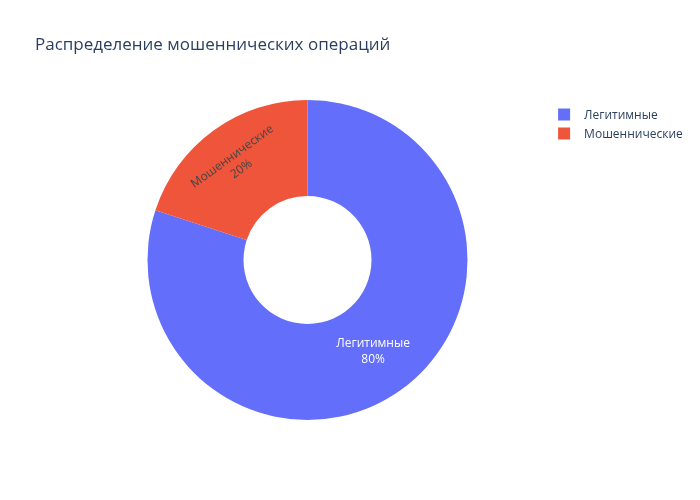

In [10]:
fraud_counts = transactions["is_fraud"].value_counts().sort("is_fraud")
px.pie(
    fraud_counts.to_pandas(),
    names=fraud_counts["is_fraud"].to_pandas().map({True: "Мошеннические", False: "Легитимные"}).to_list(),
    values="count",
    title="Распределение мошеннических операций",
    hole=0.4
).update_traces(textposition="inside", textinfo="percent+label").show(renderer="png")

### Анализ числовых признаков

In [11]:
amount_fig = px.histogram(
    transactions.to_pandas(),
    x="amount_usd",
    color="is_fraud",
    nbins=500,
    barmode="overlay",
    title="Распределение сумм транзакций",
    histnorm="percent",
    labels={"amount_usd": "Сумма (USD)"}
)

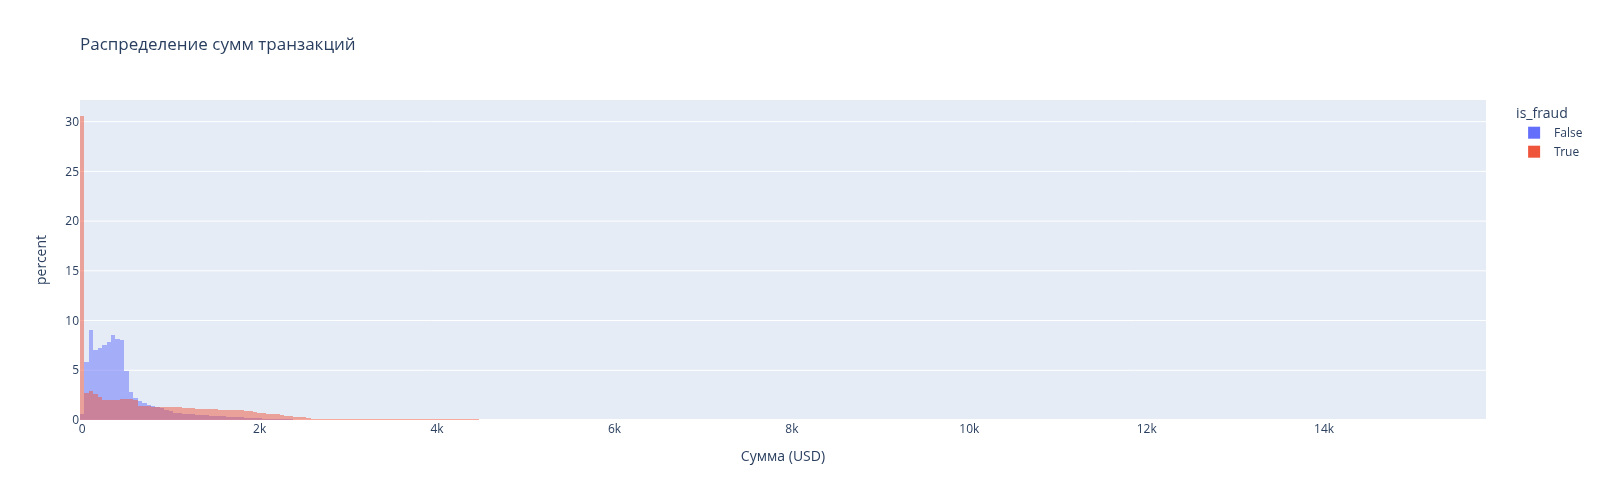

In [12]:
amount_fig.show(renderer="png", width=1600)

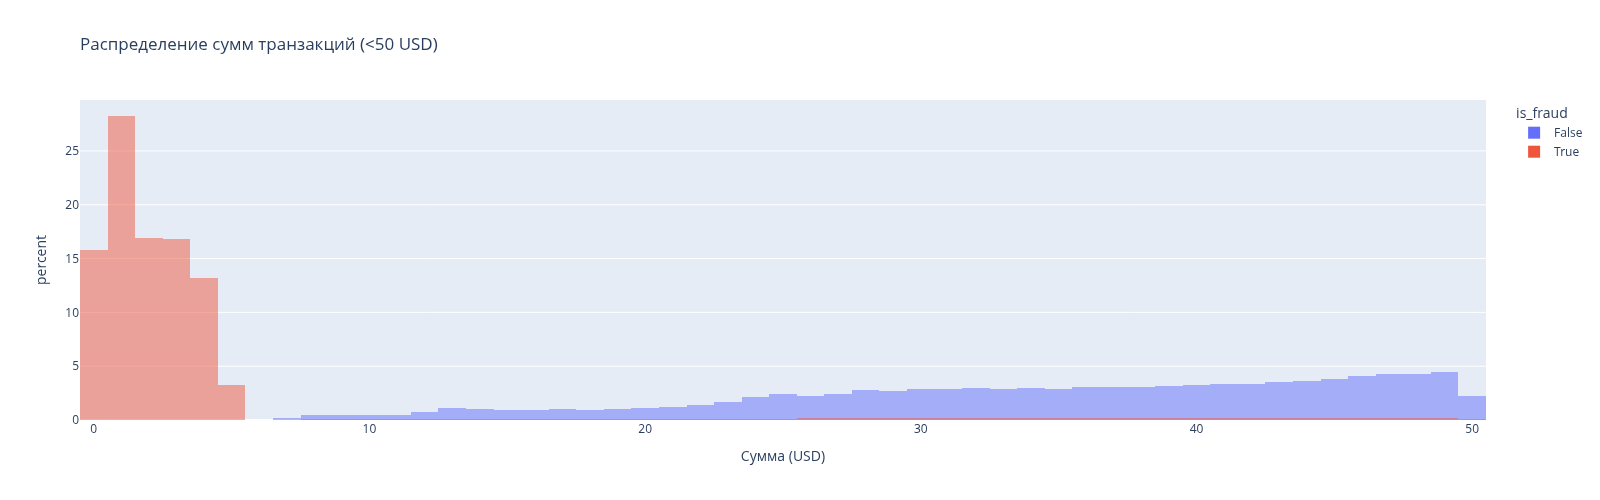

In [13]:
small_amount_fig = px.histogram(
    transactions.filter(pl.col("amount_usd") < 50).to_pandas(),
    x="amount_usd",
    color="is_fraud",
    nbins=50,
    barmode="overlay",
    title="Распределение сумм транзакций (<50 USD)",
    histnorm="percent",
    labels={"amount_usd": "Сумма (USD)"}
)
small_amount_fig.show(renderer="png", width=1600)

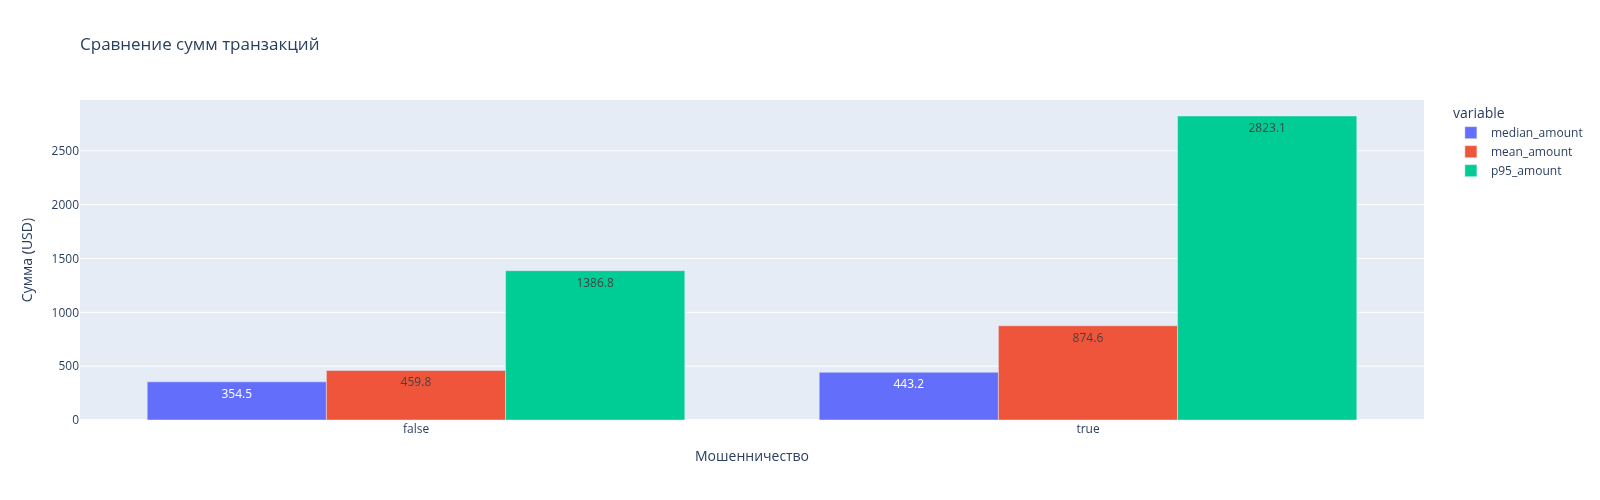

In [14]:
fraud_stats = transactions.group_by("is_fraud").agg(
    pl.median("amount_usd").alias("median_amount"),
    pl.mean("amount_usd").alias("mean_amount"),
    pl.quantile("amount_usd", 0.95).alias("p95_amount")
).to_pandas()

px.bar(
    fraud_stats,
    x="is_fraud",
    y=["median_amount", "mean_amount", "p95_amount"],
    barmode="group",
    title="Сравнение сумм транзакций",
    labels={"value": "Сумма (USD)", "is_fraud": "Мошенничество"},
    text_auto=".1f"
).show(renderer="png", width=1600)

Анализ категориальных признаков

In [15]:
cat_cols = ["vendor_category", "card_type", "channel", "is_outside_home_country", "is_high_risk_vendor"]

# Функция для создания графиков
def create_cat_subplots(col, title):
    # Подготовка данных
    df = transactions.group_by(col, "is_fraud").agg(pl.count().alias("count")).to_pandas()
    total_counts = transactions.group_by(col).agg(pl.count().alias("total")).to_pandas()
    fraud_counts = transactions.filter(pl.col("is_fraud")).group_by(col).agg(pl.count().alias("fraud_count")).to_pandas()

    # Преобразование в строки для избежания проблем с категориями
    df[col] = df[col].astype(str)
    total_counts[col] = total_counts[col].astype(str)
    fraud_counts[col] = fraud_counts[col].astype(str)

    # Создаем subplots: 1 строка, 2 колонки
    fig = make_subplots(
        rows=1, cols=2,
        specs=[[{"type": "bar"}, {"type": "pie"}]],
        subplot_titles=("Количество транзакций", "Доля мошенничества")
    )

    # Bar chart
    for fraud_status, color in zip([True, False], ['red', 'blue']):
        subset = df[df['is_fraud'] == fraud_status]
        name = "Мошенничество" if fraud_status else "Легитимные"
        fig.add_trace(
            go.Bar(
                x=subset[col],
                y=subset['count'],
                name=name,
                marker_color=color,
                showlegend=True
            ),
            row=1, col=1
        )

    # Pie chart (доля мошенничества)
    merged = total_counts.merge(fraud_counts, on=col, how='left', suffixes=('_total', '_fraud'))
    merged['fraud_rate'] = merged['fraud_count'] / merged['total']
    merged = merged.fillna(0)

    fig.add_trace(
        go.Pie(
            labels=merged[col],
            values=merged['fraud_rate'],
            name="Доля мошенничества",
            hole=0.4,
            textinfo='label+percent',
            hoverinfo='label+value+percent',
            showlegend=False
        ),
        row=1, col=2
    )

    fig.update_layout(
        title_text=f"{title}",
        height=500
    )
    return fig

# Создаем subplots для каждой категори
titles = [
    "Распределение по категориям вендоров",
    "Распределение по типам карт",
    "Распределение по каналам оплаты",
    "Транзакции за пределами страны",
    "Транзакции в высокорисковых категориях"
]

cat_figs = []
for col, title in zip(cat_cols, titles):
    cat_figs.append(create_cat_subplots(col, title))

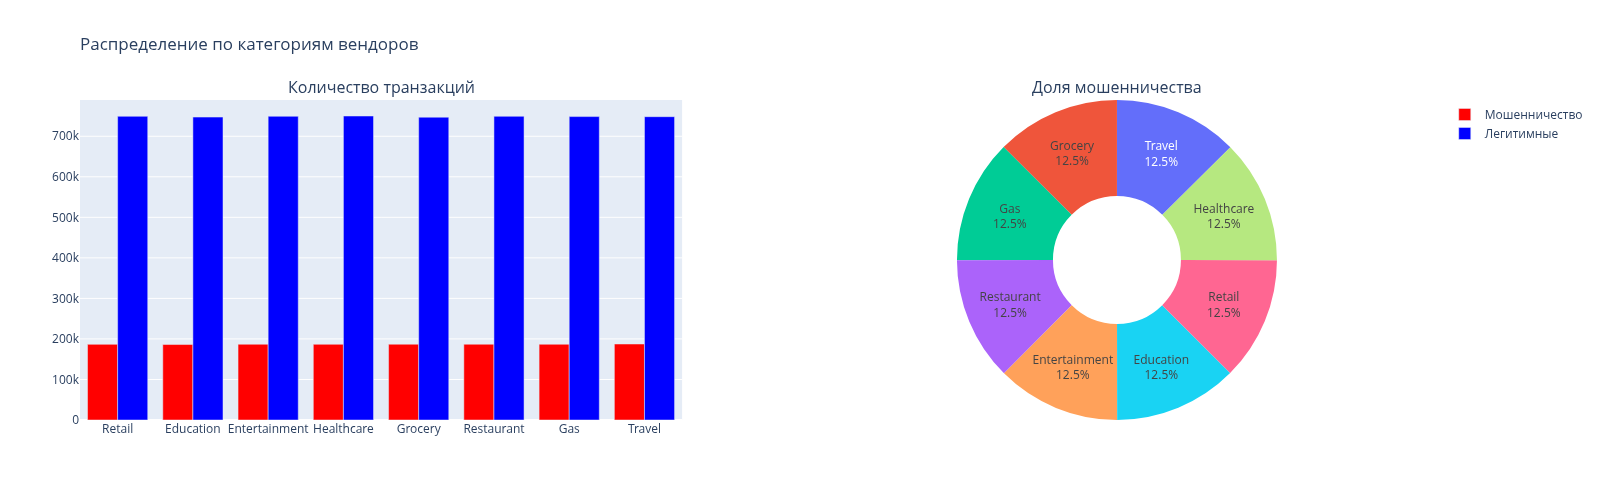

In [16]:
cat_figs[0].show(renderer="png", width=1600)

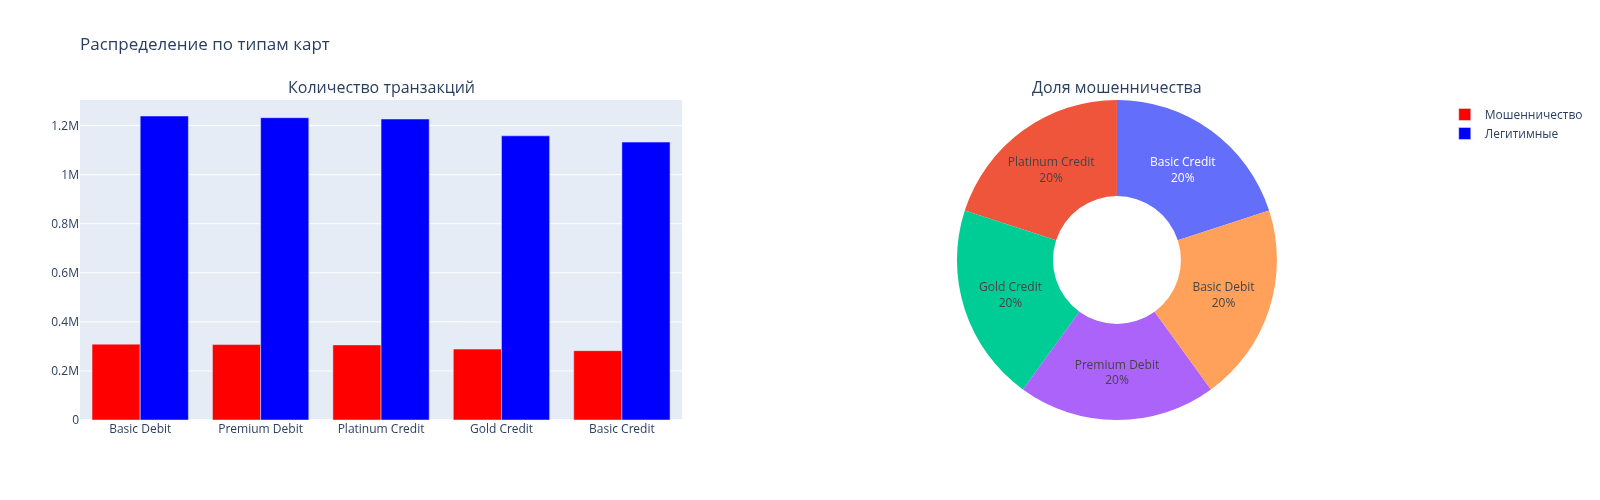

In [17]:
cat_figs[1].show(renderer="png", width=1600)

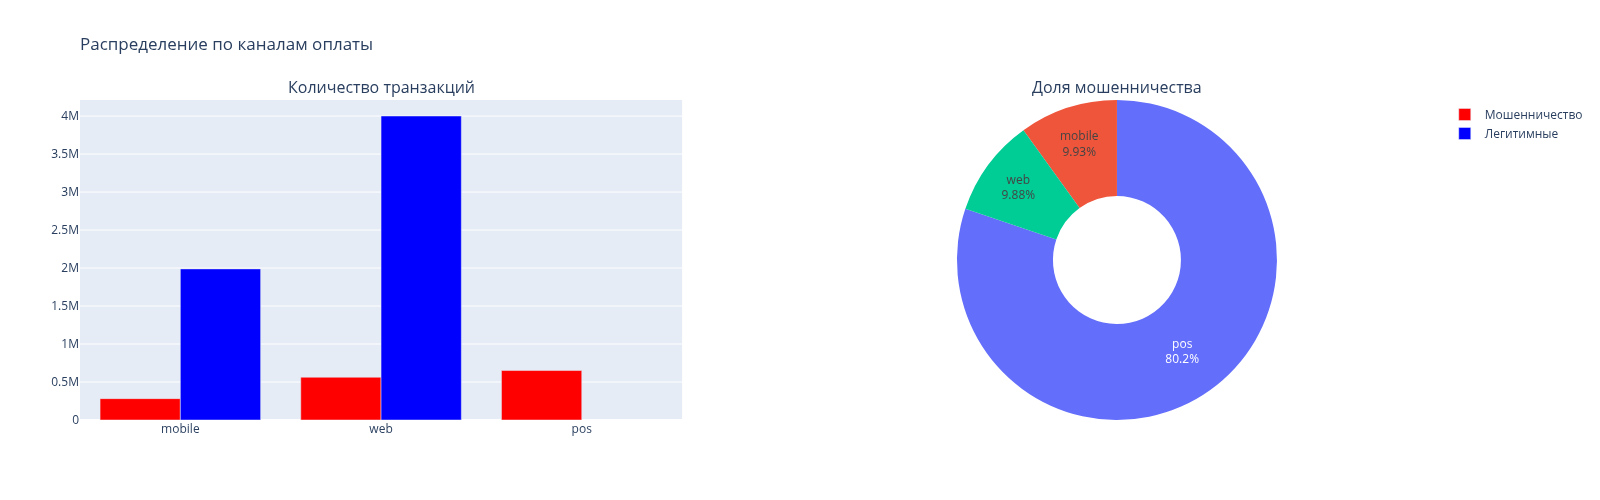

In [18]:
cat_figs[2].show(renderer="png", width=1600)

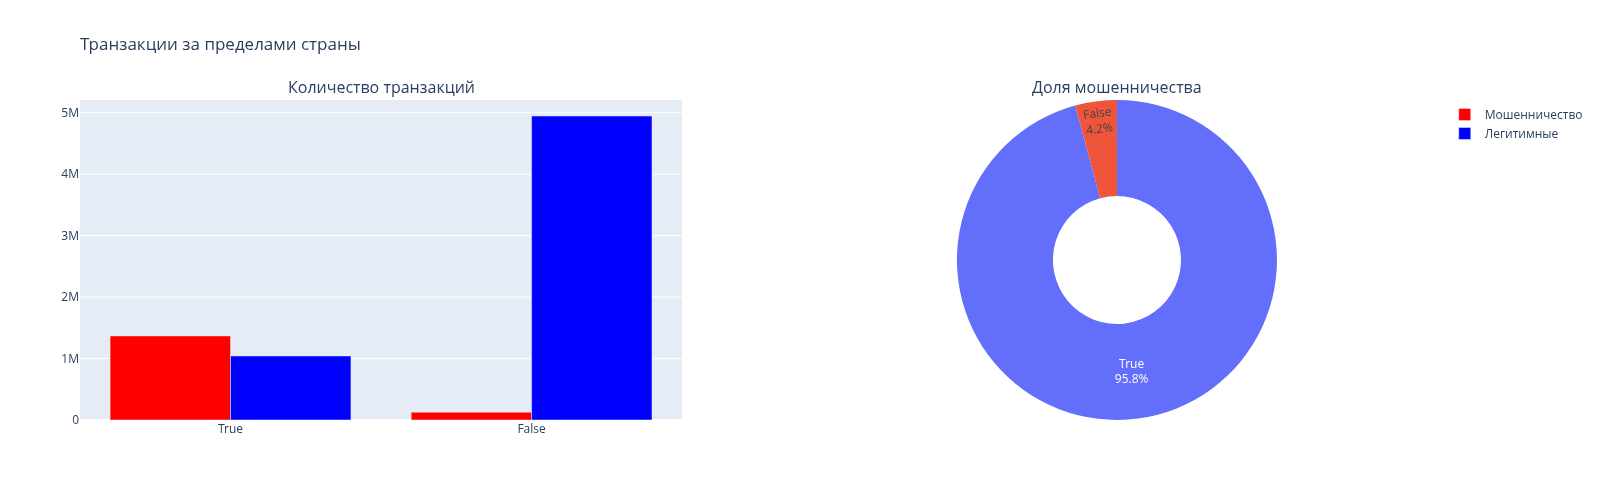

In [19]:
cat_figs[3].show(renderer="png", width=1600)

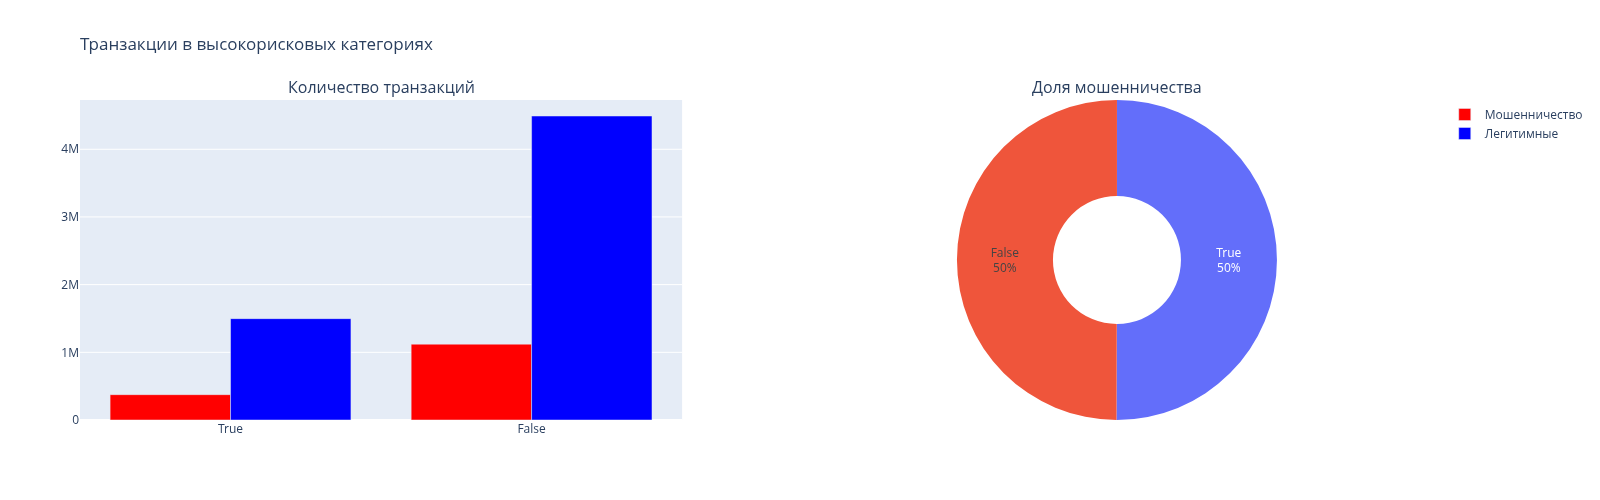

In [20]:
cat_figs[4].show(renderer="png", width=1600)

### Активность по времени

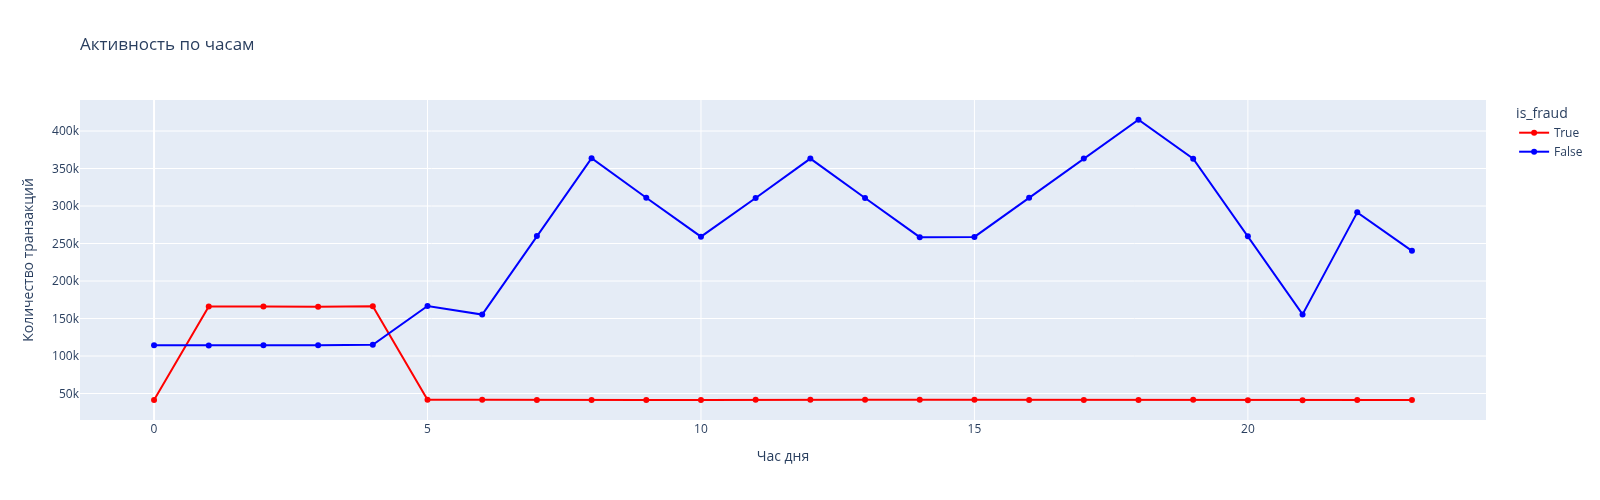

In [21]:
hourly_fraud = (
    transactions.group_by("hour", "is_fraud")
    .agg(pl.count().alias("count"))
    .sort("hour")
    .to_pandas()
)

px.line(
    hourly_fraud,
    x="hour",
    y="count",
    color="is_fraud",
    title="Активность по часам",
    markers=True,
    line_shape='linear',  # Прямые линии между точками
    category_orders={"is_fraud": [True, False]},
    color_discrete_map={True: "red", False: "blue"},
    labels={"count": "Количество транзакций", "hour": "Час дня"}
).show(renderer="png", width=1600)

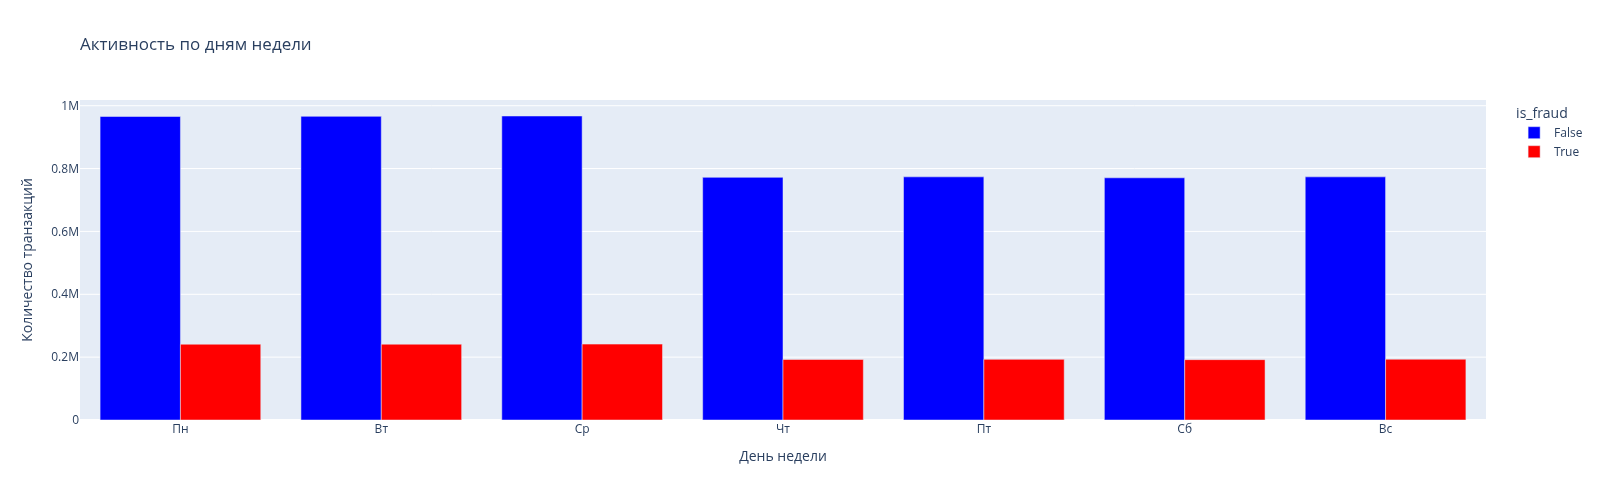

In [22]:
dow_fraud = (
    transactions.group_by("day_of_week", "is_fraud")
    .agg(pl.count().alias("count"))
    .sort("day_of_week")
    .to_pandas()
)
day_names = ["Пн", "Вт", "Ср", "Чт", "Пт", "Сб", "Вс"]
dow_fraud["day_name"] = dow_fraud["day_of_week"].map(lambda x: day_names[x - 1])

px.bar(
    dow_fraud,
    x="day_name",
    y="count",
    color="is_fraud",
    barmode="group",
    title="Активность по дням недели",
    labels={"day_name": "День недели", "count": "Количество транзакций"},
    category_orders={"day_name": day_names},
    color_discrete_map={True: "red", False: "blue"}
).show(renderer="png", width=1600)

### Географический анализ

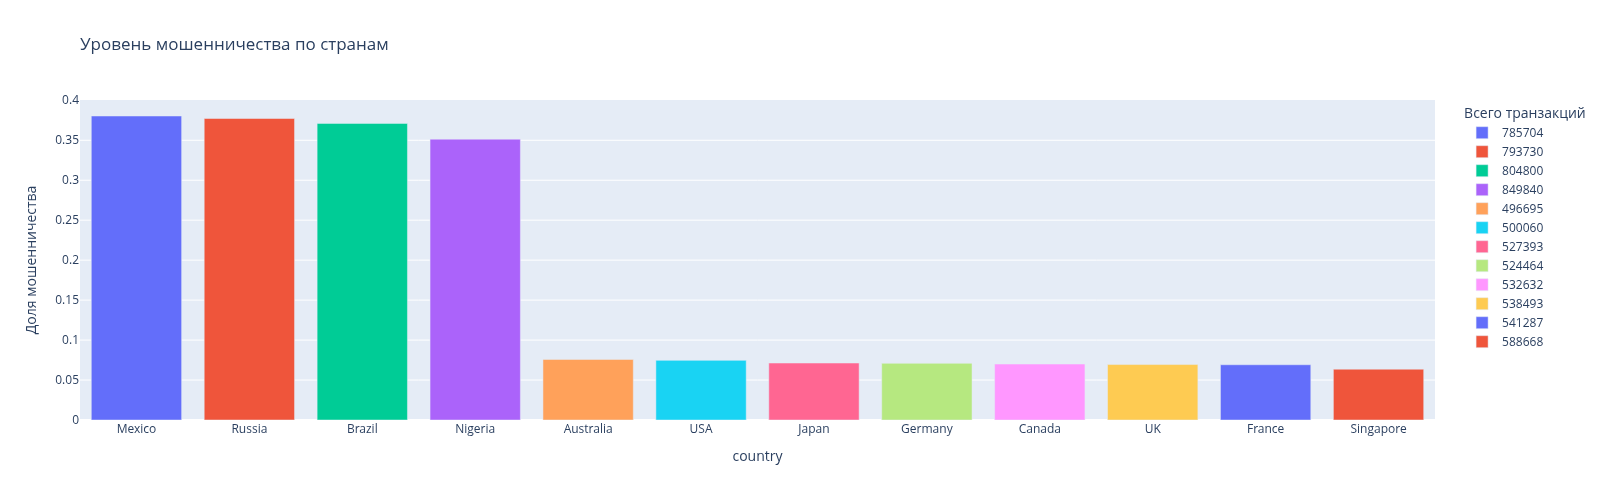

In [23]:
country_fraud = transactions.group_by("country").agg(
    pl.count().alias("total_transactions"),
    pl.mean("is_fraud").alias("fraud_rate")
).sort("fraud_rate", descending=True).to_pandas()

px.bar(
    country_fraud,
    x="country",
    y="fraud_rate",
    color="total_transactions",
    title="Уровень мошенничества по странам",
    labels={"fraud_rate": "Доля мошенничества", "total_transactions": "Всего транзакций"}
).show(renderer="png", width=1600)

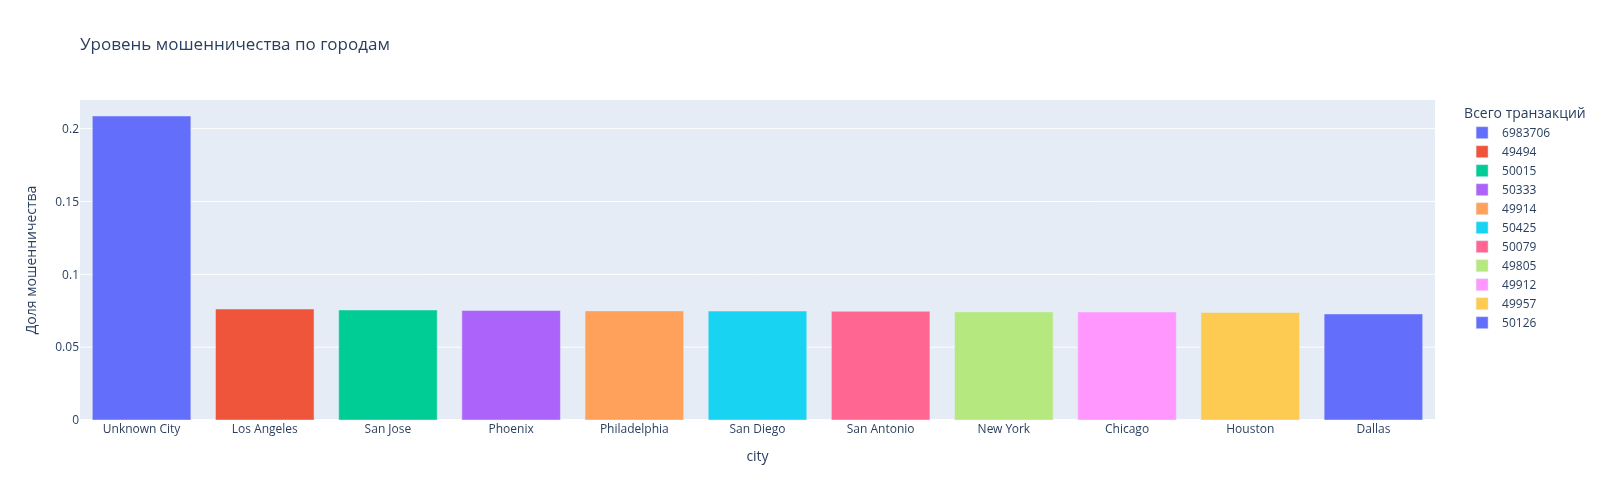

In [24]:
city_fraud = transactions.group_by("city").agg(
    pl.count().alias("total_transactions"),
    pl.mean("is_fraud").alias("fraud_rate")
).sort("fraud_rate", descending=True).to_pandas()

px.bar(
    city_fraud,
    x="city",
    y="fraud_rate",
    color="total_transactions",
    title="Уровень мошенничества по городам",
    labels={"fraud_rate": "Доля мошенничества", "total_transactions": "Всего транзакций"}
).show(renderer="png", width=1600)

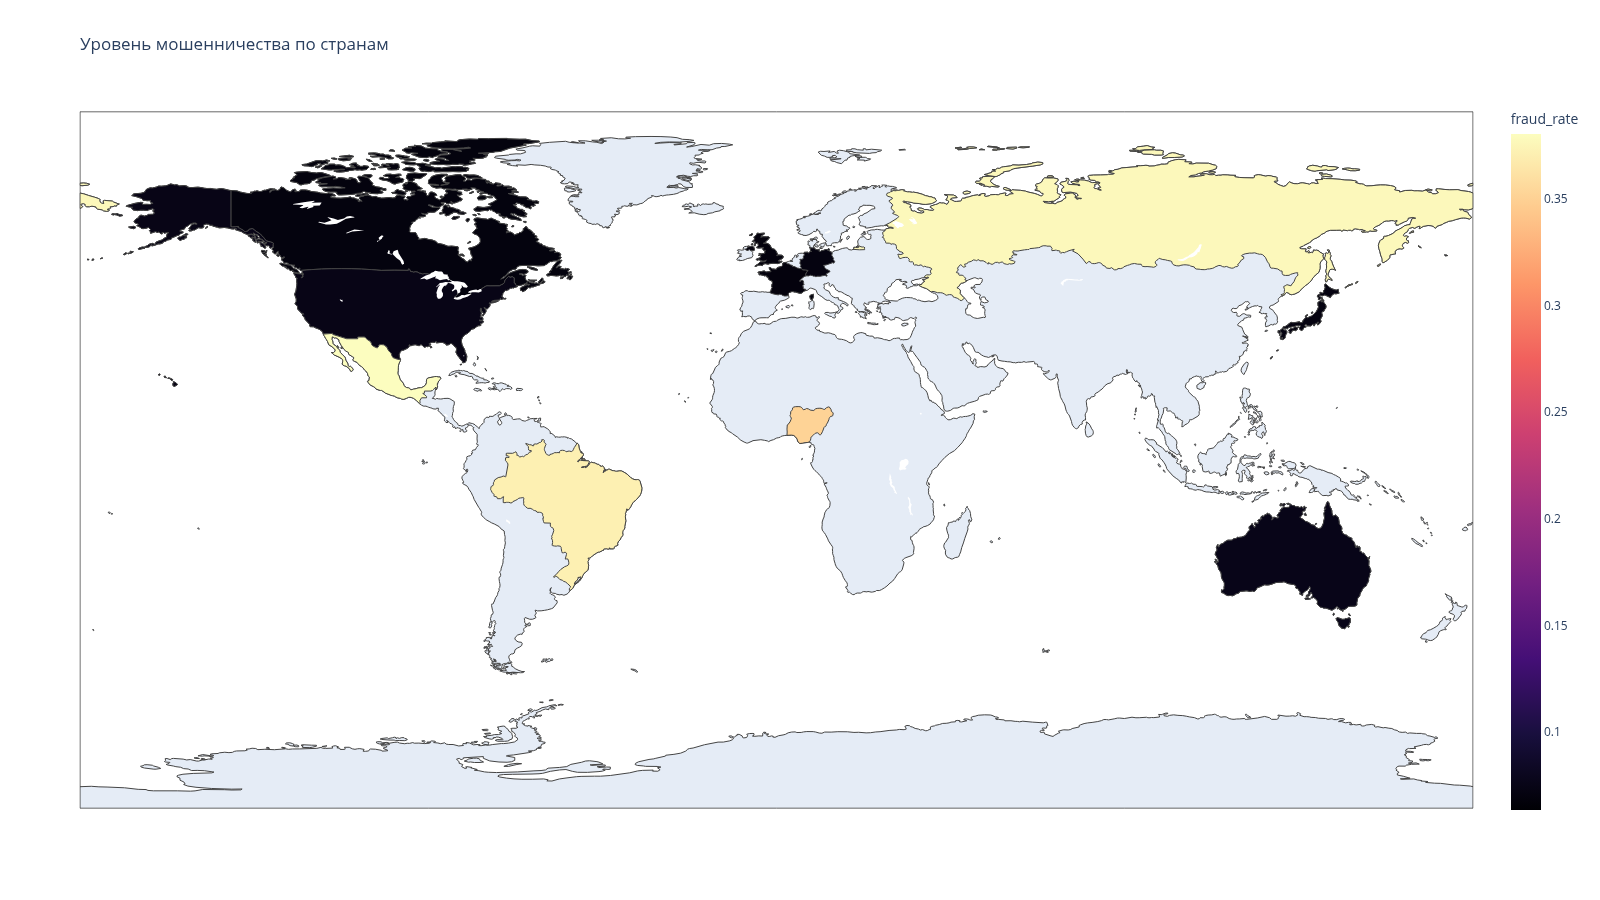

In [25]:
country_fraud = (
    transactions.group_by("country")
    .agg([
        pl.count().alias("total_transactions"),
        pl.mean("is_fraud").alias("fraud_rate")
    ])
)

px.choropleth(
    country_fraud,
    locations="country",
    locationmode="country names",
    color="fraud_rate",
    hover_name="country",
    hover_data=["total_transactions"],
    title="Уровень мошенничества по странам",
    color_continuous_scale="Magma"
).show(renderer="png", width=1600, height=900)

### Анализ активности (last_hour_activity)

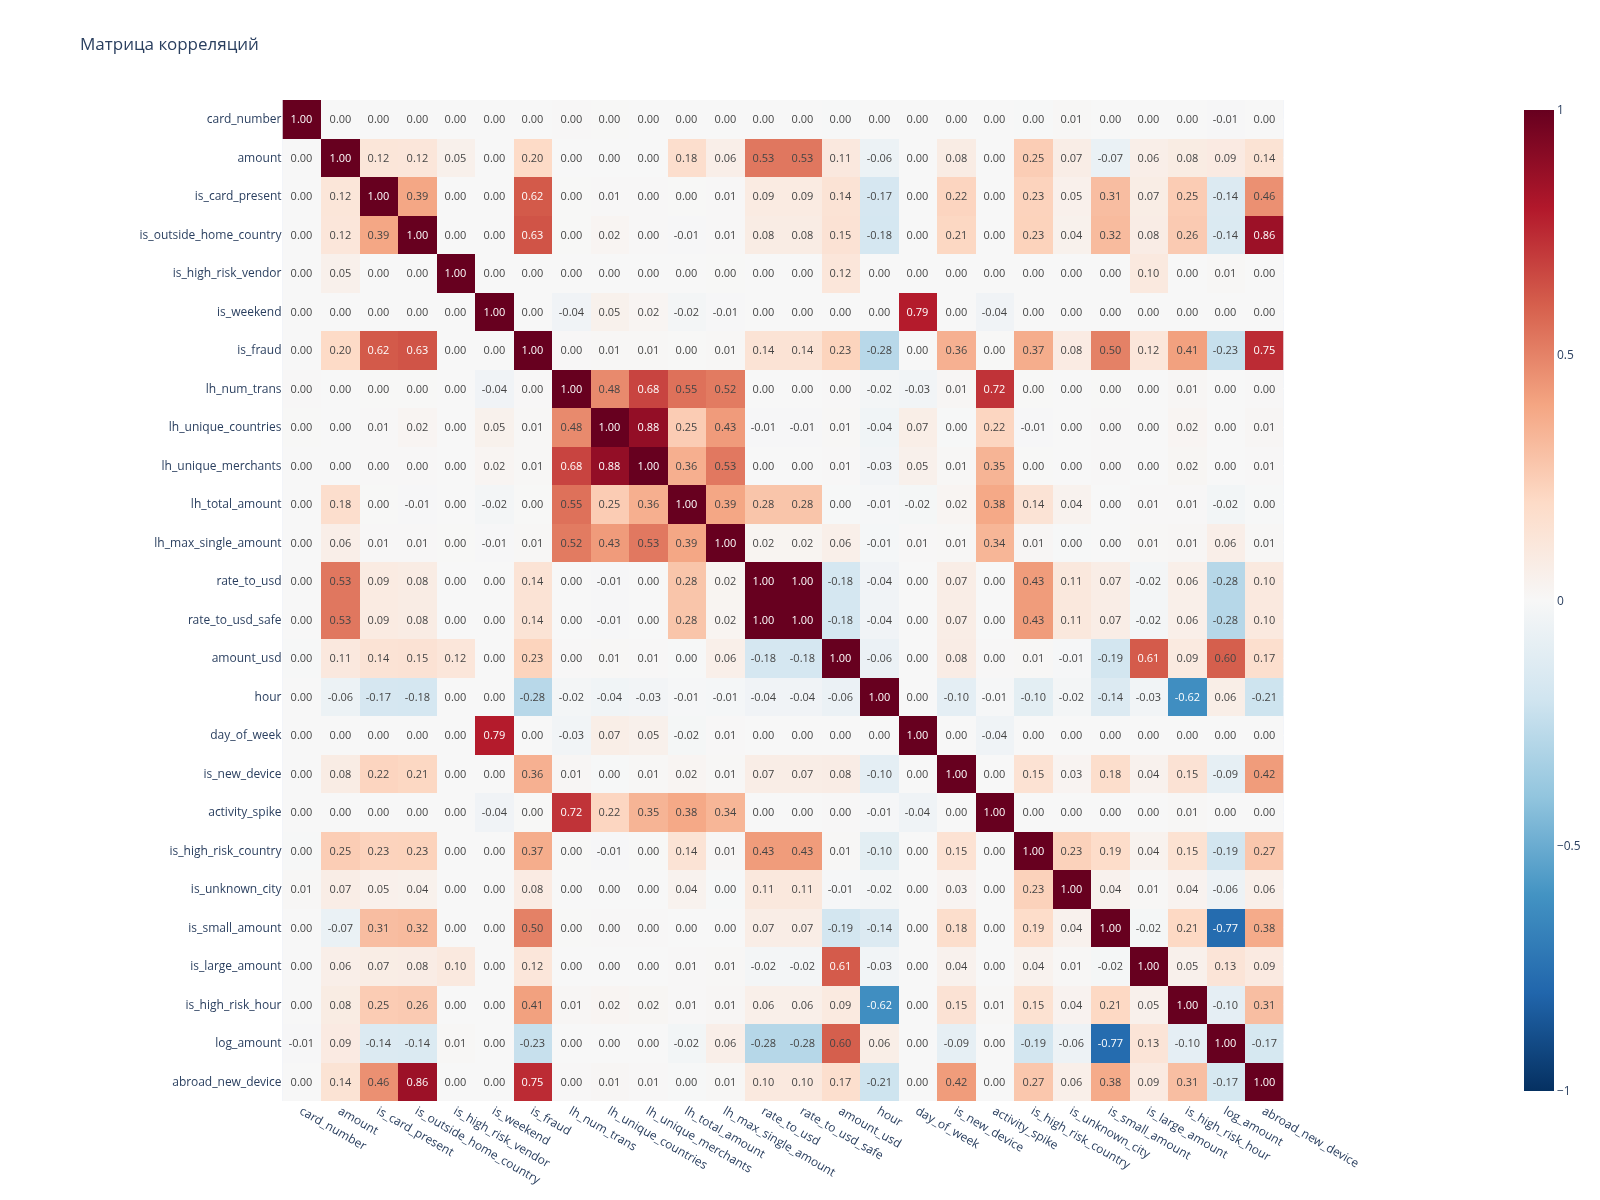

In [26]:
corr_matrix = transactions.to_pandas().corr(numeric_only=True)

px.imshow(
    corr_matrix,
    text_auto=".2f",
    title="Матрица корреляций",
    color_continuous_scale="RdBu_r",
    zmin=-1,
    zmax=1,
).show(renderer="png", width=1600, height=1200)

In [27]:
final_data = prepare_final_data(transactions)

print("Оставшиеся колонки:")
print(final_data.columns)

Оставшиеся колонки:
['vendor_category_Education', 'vendor_category_Entertainment', 'vendor_category_Gas', 'vendor_category_Grocery', 'vendor_category_Healthcare', 'vendor_category_Restaurant', 'vendor_category_Retail', 'vendor_category_Travel', 'vendor_type_airlines', 'vendor_type_booking', 'vendor_type_casual', 'vendor_type_events', 'vendor_type_fast_food', 'vendor_type_gaming', 'vendor_type_hotels', 'vendor_type_local', 'vendor_type_major', 'vendor_type_medical', 'vendor_type_online', 'vendor_type_pharmacy', 'vendor_type_physical', 'vendor_type_premium', 'vendor_type_streaming', 'vendor_type_supplies', 'vendor_type_transport', 'amount', 'city_size_large', 'city_size_medium', 'card_type_Basic Credit', 'card_type_Basic Debit', 'card_type_Gold Credit', 'card_type_Platinum Credit', 'card_type_Premium Debit', 'is_card_present', 'device_Android App', 'device_Chrome', 'device_Edge', 'device_Firefox', 'device_Safari', 'device_iOS App', 'channel_mobile', 'channel_web', 'is_outside_home_countr

Выгружаем данные

In [28]:
final_data.write_parquet("data/features.parquet")